# Track the tool tip

### Circle Video Approach

Suppose corresponding to mask $M$, we have its skeleton line $C(M)$. We hope that $C(M)$ is a non-closed curve, going all the way from the handle to the tip of the tool. Therefore, the handle and tip points (collectively called endpoints) will only have 1 pixel adjacent to them in the neighborhood. Due to noise, $C(M)$ may consist of more than one non-closed curve, but we are not interested in the endpoints from those noisy curves.  
After having a set of endpoints $E(M)$, we define an abstract point $A$ as the center of the view. So the handle point will be the point closest to the boundary, in other words furthest from the center:
$$H(M)=\underset{I\in E(M)}{\mathop{\arg \max }}\,(dist(A,I) )$$
If you know the handle point, determining the tip point is easy, just find in $E(M) \setminus \{H(M)\}$ the point farthest from the ending point.
$$T(M)=\underset{I \in E(M) \setminus \{H(M)\}}{\mathop{\arg \max }}\,(dist(H(M),I))$$

*For example here, if we consider the yellow pixel in the center to see if it is an endpoint, then we look at its 8 neighboring squares. In these 8 squares there is only 1 other yellow pixel, so the conclusion is that the yellow pixel in the center is an endpoint.*

For each mask $Q$ corresponding to a tool, we use the identified tip point $T(Q)$, we will track it along with other points. These points are divided into 2 parts:  
**Part 1: POI (Point of interest):** Points along the skeleton line $C(Q)$, of course this POI part will contain $T(Q)$.  
**Part 2: Support grid:** In mask $Q$, we sample dense points in the mask according to a certain grid size.  
Adding these two parts together, we get a set of queries, and use these queries to put into CoTracker for processing.  

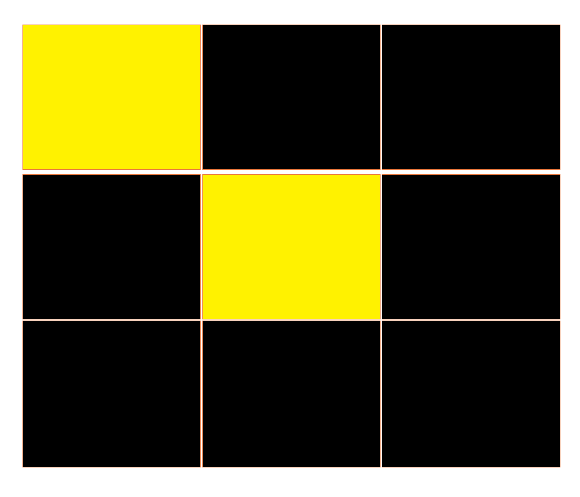

In [1]:
import supervision as sv
import numpy as np
import torch


In [2]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
from cotracker_utils import *
# video_path = 'D:/tool_test_02.mp4'
# # display_video(video_path) 
# # TODO: display_video is so slow

Using cache found in C:\Users\DELL/.cache\torch\hub\facebookresearch_co-tracker_main
Using cache found in C:\Users\DELL/.cache\torch\hub\facebookresearch_co-tracker_main


##### Testing:

In [4]:
# import cv2
# cap = cv2.VideoCapture(video_path)
# length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# arr = np.arange(0, length, 200)
# print(len(arr))

In [5]:
# #abstract point for tool_test_01 : 351, 624
# #abstract point for tool_test_02 : 650, 366
# from tqdm import tqdm
# for frame_idx in tqdm(arr):
#     test_image = extract_frame(video_path,frame_idx)
#     Testing(test_image, abstract_point=[366, 650] , save_dir = 'D:/testingtooltip/testB'+str(frame_idx)+'.jpg'
#     , save_error = 'D:/testingtooltip/errorB'+str(frame_idx)+'.jpg')

### Rectangle Video Approach

Because each segmentation mask $M$ is always inside the bounding box (says there are 4 edges $c_1, c_2, c_3, c_4$), and the handle of the surgical tool always touches the edge of the view, so assuming the segmentation has no errors then $ M$ also touches the edge of the view. So that at least one edge $c_i$ ($1 \leq i \leq 4$) touches the view edge. Considering that edge as the abstract edge, we find the starting point of the tool on the skeleton line $C(M)$ which is the point closest to the abstract edge.


There are 2 directions to determine the abstract edge in practice:
- Find the edge of the bounding box closest to the boundary, this way you can find the abstract edge in all cases, even if the bounding box is noisy, and there will always be only 1 abstract edge.
- Set threshold = $\varepsilon$, edges close to the boundary with a difference less than the threshold are considered abstract edges. If there is 1 abstract edge, it is similar to the above case. If there are 2 abstract edges (say AB, AC), then the endpoint closer to A will be the handle. This method is good at removing outlier segmentations (not tools), but the threshold must be set appropriately.


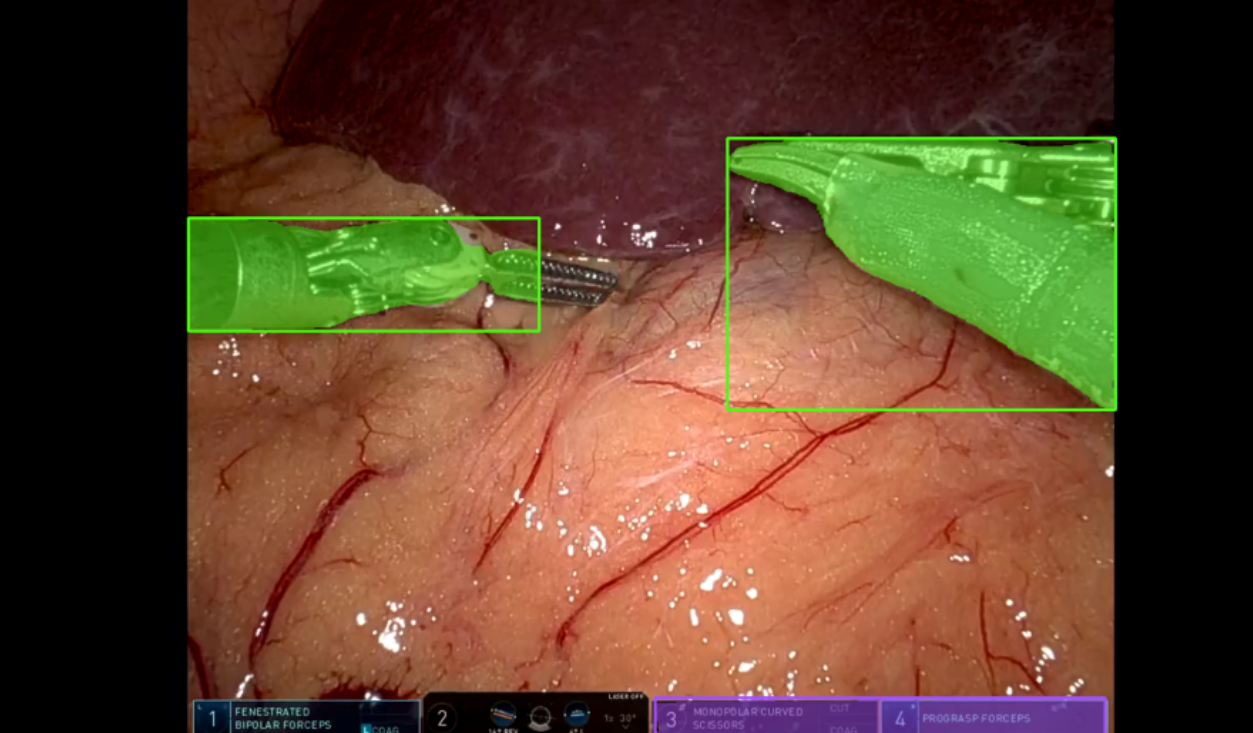

In [5]:
ROI = [[191, 1086], [0, 674]]

In [6]:
box_annotator = sv.BoxAnnotator()

In [17]:
rectangle_video_path = 'D:/tool_test_03.mp4'
frame = extract_frame(rectangle_video_path,0)
s_frame = crop(frame,ROI)
detections = get_sv_detections(s_frame)

print(detections.xyxy)
hw = []
for i, box in enumerate(detections.xyxy):
    h = box[3] - box[1]
    w = box[2] - box[0]
    hw.append(h*w)
    hw.append(detections.confidence[i])


[[523. 134. 894. 405.]
 [  1. 218. 403. 332.]]


In [29]:
HW = []
for i in range(10):
    framex = extract_frame(rectangle_video_path, i)
    s_frame = crop(framex, ROI)
    detections = get_sv_detections(s_frame)
    for i,box in enumerate(detections.xyxy):
        h = box[3] - box[1]
        w = box[2] - box[0]
        area_ratio = h*w/(s_frame.shape[0]*s_frame.shape[1]) # ti le dien tich cua bounding box so voi toan khung hinh
        HW.append([area_ratio,detections.confidence[i]]) # area_ratio, confidence
        

    

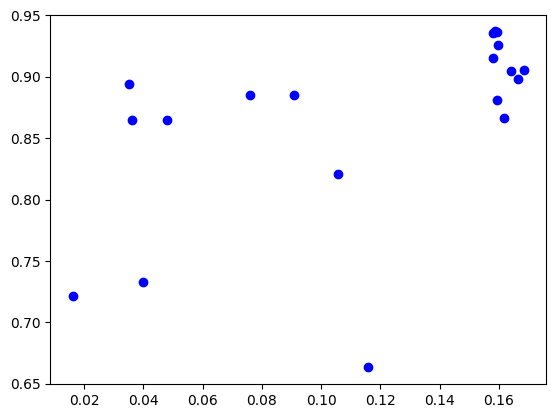

In [30]:
points = np.array(HW)
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Các điểm')


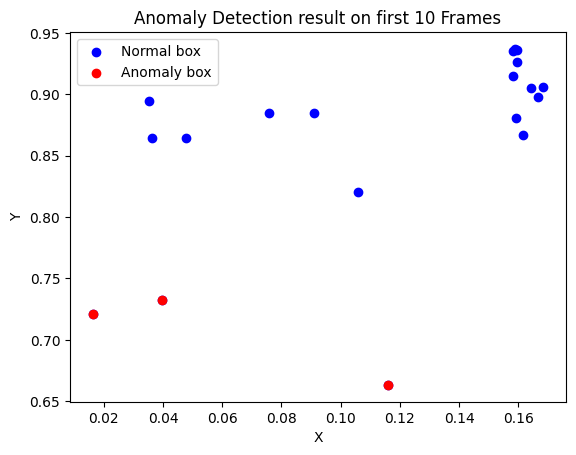

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np


dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(points)

labels = dbscan.labels_

outliers = points[labels == -1]
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Normal box')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Anomaly box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Anomaly Detection result on first 10 Frames')
plt.legend()
plt.show()

# for each mask M, f(M) < f(M') if M less confidence than M
# if M.conf < M'.conf => f(M) < f(M') 
# if area of M < area of M' => f(M) < f(M')

In [ ]:
# (F, x, y) // track (x,y) from frame F

In [27]:
[np.count_nonzero(detections.mask[0]), np.count_nonzero(detections.mask[1]), np.count_nonzero(detections.mask[2])]

[39272, 60965, 12472]

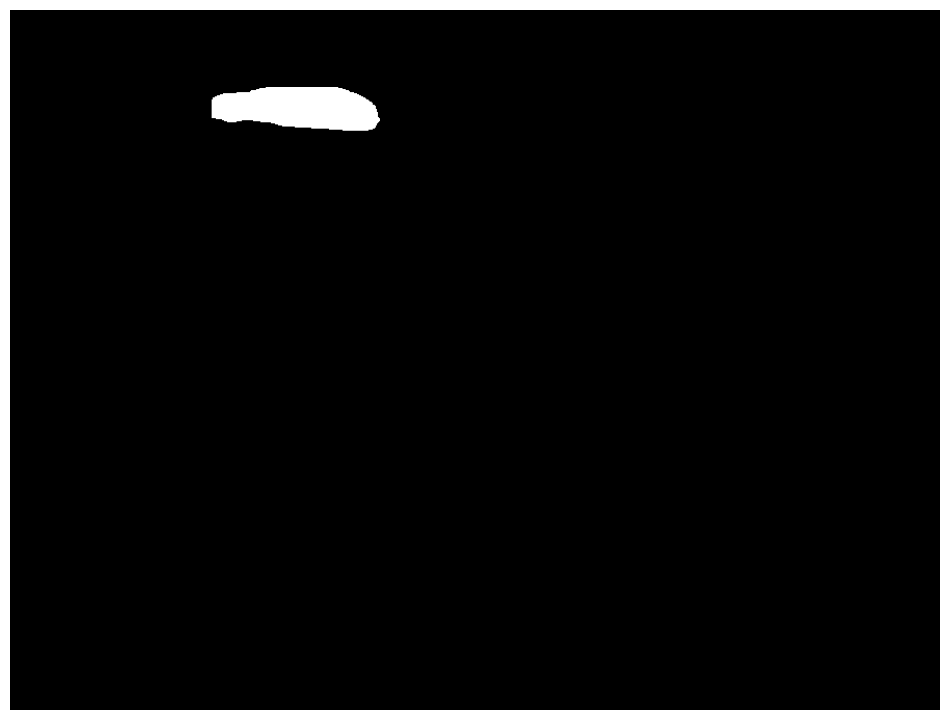

In [21]:
sv.plot_image(detections.mask[2])

In [9]:
from tqdm import tqdm
RunName = "Thử thuật toán hình chữ nhật, ngày 14/3/2024"
with open('log.txt', 'w', encoding="utf-8") as f:
    f.write(RunName + "\n")
for frame_idx in tqdm(range(100)):
    frame = extract_frame(rectangle_video_path, frame_idx)
    txt = Testing_rectangle(frame, ROI, 'D:/testingtooltip/testE'+str(frame_idx)+'.jpg', 'D:/testingtooltip/errorE'+str(frame_idx)+'.jpg')
    with open('log.txt', 'a', encoding="utf-8") as f:
        f.write(str(frame_idx) + ": " + txt + "\n") 

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


### Debug:

In [10]:
# error_frame = extract_frame(rectangle_video_path, 98)
# error_frame = crop(error_frame, ROI)
# sv.plot_image(error_frame)

In [11]:
masks = get_mask(error_frame)
skeletons = skeletonize(masks)
bounding_boxes = get_bb(error_frame)

NameError: name 'error_frame' is not defined

In [ ]:
endpoints = get_endpoints(skeletons[0])
endpoints

[(588, 350), (671, 574)]

In [ ]:
abstract_edge = get_abstract_edge(bounding_boxes[0], ROI)
abstract_edge

[3, 674.0]

In [ ]:
get_handle(abstract_edge, endpoints)

(671, 574)

## Train model 
B1: Trên terminal, gõ pip show ultralytics để tìm thư mục của thư viện.  
B2: Cài đặt dữ liệu bên trong thư mục ultralytics/cfg.  

## Track

In [ ]:
my_model = TrackModel(video_path, queries = queries, segm_mask = torch.from_numpy(final_mask[None, None]).float(), grid_size = 40)
my_model.run()

NameError: name 'video_path' is not defined

In [ ]:
my_model.show('D:/', video_path)